# Computing Zonal Statistics with ASTER Thermal Infrared GeoTIFFs




*Portions of this notebook were derived from [this example with Sentinel satellite imagery](https://github.com/shakasom/zonalstatistics/).*

---
To do:
- fix nodata issue in masking (you can see all the zeros I end up with in this histograms, which I want to convert to nan values so that I can ignore them)

---

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import rasterio as rio
import rasterio.plot as rioplt
from rasterio.mask import mask
import matplotlib.pyplot as plt

### Open an ASTER TIR image

In [2]:
a = rio.open(r"\\j-lundquist-3.ce.washington.edu\storage\spestana\ASTER\AST_L1T\geotiff\T\T_Tuolumne-and-CUES\T_both\AST_L1T_00311262018060119_20181128034140_15697_T.tif")

In [3]:
a.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 932,
 'height': 824,
 'count': 3,
 'crs': CRS({'init': 'epsg:32611'}),
 'transform': Affine(90.0, 0.0, 269865.0,
        0.0, -90.0, 4232115.0)}

In [4]:
a.count, a.width, a.height

(3, 932, 824)

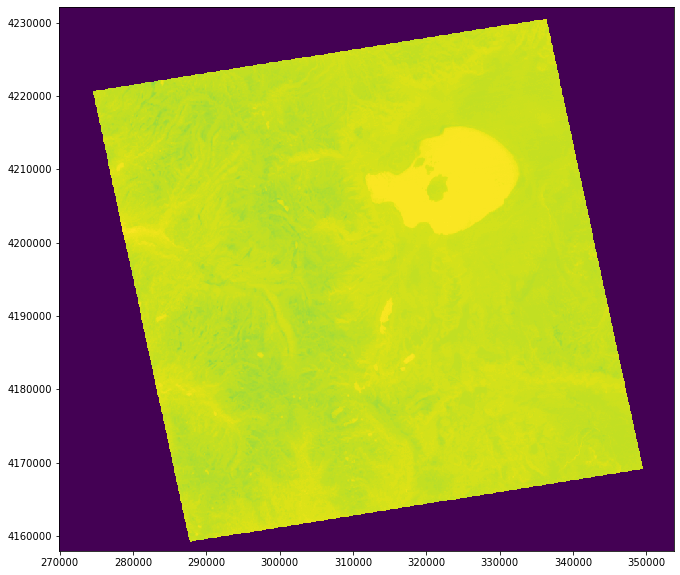

In [5]:
fig, ax = plt.subplots(1, figsize=(12, 10))
rioplt.show(a, ax=ax)
plt.show()

### Open a shapefile
(these will be the GOES pixel footprints)

In [6]:
testshape = gpd.read_file(r"C:\Users\steve\Desktop\test1.shp")
testshape.head()

,id,geometry
0,0,"POLYGON ((-119.31453 37.86398, -119.30652 37.9..."


Make sure our shapefile is the same CRS as the ASTER TIR image

In [7]:
print('ASTER CRS: {}'.format(a.crs))
print('Shapefile CRS: {}'.format(testshape.crs))

ASTER CRS: +init=epsg:32611
Shapefile CRS: {'init': 'epsg:4326'}


In [8]:
testshape = testshape.to_crs(a.crs)

In [9]:
print('ASTER CRS: {}'.format(a.crs))
print('Shapefile CRS: {}'.format(testshape.crs))

ASTER CRS: +init=epsg:32611
Shapefile CRS: +init=epsg:32611


### Plot the shapefile on top of the ASTER image to see where we are

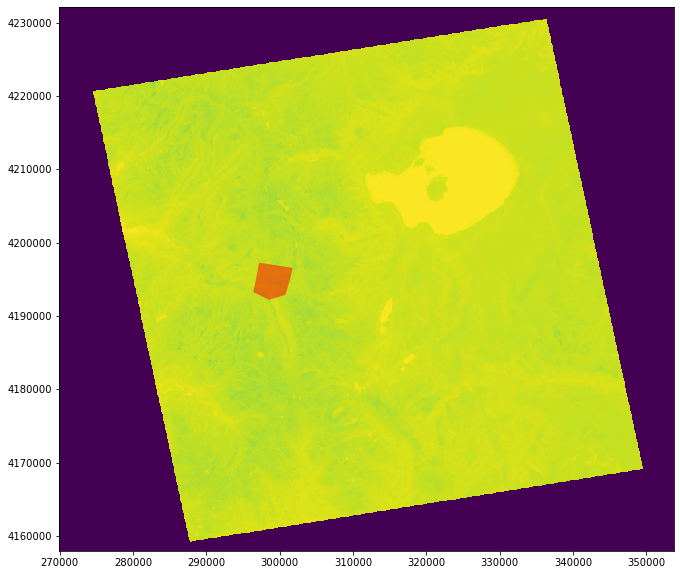

In [10]:
fig, ax = plt.subplots(figsize=(12, 10))
rioplt.show(a, ax=ax)
testshape.plot(ax=ax, color="red", alpha=.50)
plt.show();

### Mask the ASTER TIR image to the area of the shapefile

In [11]:
masked, mask_transform = mask(dataset=a, 
                              shapes=testshape.geometry,
                              crop=True,
                              all_touched=True,
                              filled=True)

# We still have all three bands in here
masked.shape

(3, 57, 61)

### Calculate zonal statistics for this area
(mean, max, min, std:)

In [12]:
means_per_band = masked.mean(axis=(1,2))
max_per_band = masked.max(axis=(1,2))
min_per_band = masked.min(axis=(1,2))
std_per_band = masked.std(axis=(1,2))

### Plots

Band_n: 0
Mean: 115.25337935001438
Max: 162
Min: 0
Std: 69.8172679079356
Band_n: 1
Mean: 104.23497267759562
Max: 147
Min: 0
Std: 63.152710879093036
Band_n: 2
Mean: 99.95427092320966
Max: 141
Min: 0
Std: 60.56540644770467


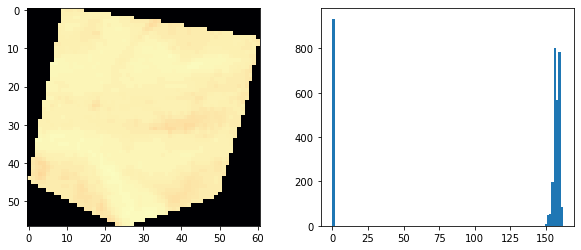

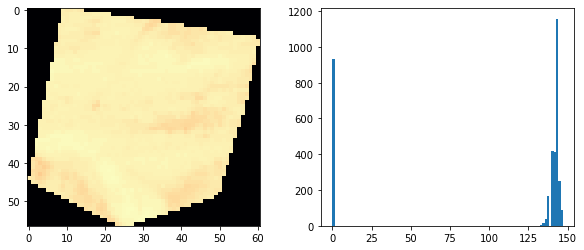

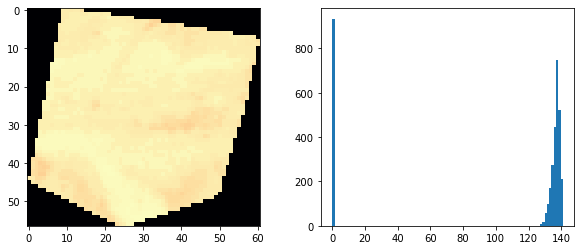

In [13]:
# For each band in the ASTER image
for band_n in range(a.count):
    fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(10,4), gridspec_kw={'width_ratios': [1, 1]})
    
    # Plot image
    rio.plot.show(masked[band_n], ax=ax[0], cmap='magma')
    
    # Print zonal statistics
    print('Band_n: {}\nMean: {}\nMax: {}\nMin: {}\nStd: {}'.format(band_n,
                                                                   means_per_band[band_n],
                                                                   max_per_band[band_n],
                                                                   min_per_band[band_n],
                                                                   std_per_band[band_n]))
    # Plot histogram
    #rio.plot.show_hist(
    #masked[band_n], bins=50, lw=0.0, stacked=False, alpha=0.3, ax=ax[1],
    #histtype='stepfilled', title="Histogram", c='r')
    values = masked[band_n].flatten()
    ax[1].hist(values, bins=100);